In [28]:
import os
import builtins
import json
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import radar_factory

from pathlib import Path
from scipy.stats import kruskal, mannwhitneyu, wilcoxon

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 14
# plt.rcParams['text.usetex'] = True
plt.rcParams['text.usetex'] = False

### Load problems

In [2]:
# we need to know some things about the data
data_path = './problems/'

all_files  = list(os.listdir(data_path)) if os.path.isdir(data_path) else [ os.path.basename(data_path) ]
data_files = sorted([ f for f in all_files if f.endswith('.json') ])

problem_info = {}

# aggregate problem information that we can use to evaluate expressions
for f in data_files:
    with builtins.open(os.path.join(data_path, f), 'r') as h:
        info           = json.load(h)
        metadata       = info['metadata']
        target         = metadata['target']
        training_rows  = metadata['training_rows']
        training_start = training_rows['start']
        training_end   = training_rows['end']
        test_rows      = metadata['test_rows']
        test_start     = test_rows['start']
        test_end       = test_rows['end']
        problem_name   = metadata['name']
        problem_csv    = metadata['filename']

    problem_data = pd.read_csv(os.path.join(data_path, problem_csv))
    problem_info[problem_name] = {
        'name' : problem_name,
        'training_range' : (training_start, training_end),
        'test_range' : (test_start, test_end),
        'target' : target,
        'data' : problem_data
    }

def range_size(problem):
    a, b = problem_info[problem]['training_range']
    return b-a

### Load results

In [3]:
df = pd.read_csv('./results_full.csv.gz')

### Structure of the results

The full experiment results are available in a single file which contains run statistics from all the backends. Additionally, this file has four extra columns, `r2_train_v`, `r2_test_v`, `r2_train_b` and `r2_test_b`, which represent the R2 values of the final expressions re-evaluated with the `Stl` backend (`_v` suffix) and with the original backend `_b` suffix, but with linear scaling.

In [4]:
df1 = df[df.jac_eval == 0]
df2 = df[df.jac_eval > 0]

In [5]:
for k, v in df1.groupby(['backend', 'problem']):
    print(k, v[v.generation == 0].shape)

('Eigen', 'Airfoil Self-Noise') (100, 24)
('Eigen', 'Chemical-I') (100, 24)
('Eigen', 'Concrete Compressive Strength') (100, 24)
('Eigen', 'Friedman-I') (100, 24)
('Eigen', 'Friedman-II') (100, 24)
('Eigen', 'Poly-10') (100, 24)
('Eigen', 'Spatial Coevolution') (100, 24)
('Eigen', 'Vladislavleva-1') (100, 24)
('Eigen', 'Vladislavleva-2') (100, 24)
('Eigen', 'Vladislavleva-3') (100, 24)
('Eigen', 'Vladislavleva-4') (100, 24)
('Eigen', 'Vladislavleva-5') (100, 24)
('Eigen', 'Vladislavleva-6') (100, 24)
('Eigen', 'Vladislavleva-7') (100, 24)
('Eigen', 'Vladislavleva-8') (100, 24)
('Mad_Transcendental_Fast', 'Airfoil Self-Noise') (100, 24)
('Mad_Transcendental_Fast', 'Chemical-I') (100, 24)
('Mad_Transcendental_Fast', 'Concrete Compressive Strength') (100, 24)
('Mad_Transcendental_Fast', 'Friedman-I') (100, 24)
('Mad_Transcendental_Fast', 'Friedman-II') (100, 24)
('Mad_Transcendental_Fast', 'Poly-10') (100, 24)
('Mad_Transcendental_Fast', 'Spatial Coevolution') (100, 24)
('Mad_Transcendent

### Filter the dataframe and keep only run stats from the last generation (which also contain the final expression and energy value)

In [6]:
runs_without_nls = df1.dropna(subset=['expression'], axis=0).reset_index(drop=True)
runs_with_nls = df2.dropna(subset=['expression'], axis=0).reset_index(drop=True)

In [7]:
runs_without_nls.r2_train_v = runs_without_nls.r2_train_v.fillna(0.0).clip(0, 1)
runs_without_nls.r2_train_b = runs_without_nls.r2_train_b.fillna(0.0).clip(0, 1)

runs_without_nls.r2_test_v = runs_without_nls.r2_test_v.fillna(0.0).clip(0, 1)
runs_without_nls.r2_test_b = runs_without_nls.r2_test_b.fillna(0.0).clip(0, 1)

runs_with_nls.r2_train_v = runs_with_nls.r2_train_v.fillna(0.0).clip(0, 1)
runs_with_nls.r2_train_b = runs_with_nls.r2_train_b.fillna(0.0).clip(0, 1)

runs_with_nls.r2_test_v = runs_with_nls.r2_test_v.fillna(0.0).clip(0, 1)
runs_with_nls.r2_test_b = runs_with_nls.r2_test_b.fillna(0.0).clip(0, 1)

In [8]:
# these were the experiment settings
n_runs = 100
population_size = 1000

# fill in some values which will make it easier to compute the stats later on
def fill_generational_deltas(mydata):
    # convert cumulative stats to per-generation stats
    mydata['res_eval_delta'] = mydata.res_eval.diff()
    mydata['jac_eval_delta'] = mydata.jac_eval.diff()

    # correct for run boundaries
    mydata['res_eval_delta'] = mydata.apply(lambda x: x.res_eval if (x.res_eval_delta < 0 or np.isnan(x.res_eval_delta)) else x.res_eval_delta, axis=1)
    mydata['jac_eval_delta'] = mydata.apply(lambda x: x.jac_eval if (x.jac_eval_delta < 0 or np.isnan(x.jac_eval_delta)) else x.jac_eval_delta, axis=1)

    # add n_instances and compute n_ops
    mydata['n_instances'] = mydata.problem.apply(lambda x: range_size(x))
    mydata['n_ops'] = mydata.apply(lambda x: x.n_instances * (x.res_eval_delta + 2 * x.jac_eval_delta) * x.avg_len, axis=1)

    return mydata

In [9]:
df1 = fill_generational_deltas(df1)
df2 = fill_generational_deltas(df2)

#### NPS and NPW

$$
    \begin{aligned}
    \text{Number of node operations} &= n_\text{instances} \left( n_\text{res} + 2 n_\text{jac} \right) \bar{l} & & \text{(estimate for one population)}\\\\
    \text{NPS} &= \frac{\text{Total number of node operations}}{\text{Total runtime}} & & \text{(nodes per second)}\\\\
    \text{NPW} &= \frac{\text{Total number of node operations}}{\text{Total energy}} & & \text{(nodes per watt)}
    \end{aligned}
$$ 
where each "total" value is the sum of the relevant measure over all relevant generations/runs/problems, and where $n_\text{instances}$ is the number of fitness cases for a given problem, $n_\text{res}$ and $n_\text{jac}$ are the total number of "residual" and "Jacobian" evaluations for a particular population (i.e., for one generation), and $\bar{l}$ is the average length of programs in a particular population.

### Compute NEPS and NPW

In [10]:
backends = df1.backend.unique()
results = {
    'backend': backends,
    'npw_without_nls': [],
    'npw_with_nls': [],
    'nps_without_nls': [],
    'nps_with_nls': [],
    'energy_without_nls': [],
    'energy_with_nls': [],
    'r2_without_nls': [],
    'r2_with_nls': [],
    'abs_r2_without_nls': [],
    'abs_r2_with_nls': [],
    'rel_r2_without_nls': [],
    'rel_r2_with_nls': [],
    'avg_len_without_nls': [],
    'avg_len_with_nls': [],
    'elapsed_without_nls': [],
    'elapsed_with_nls': []
}

names = {
    'Mad_Transcendental_Fast': 'Mad-16',
    'Mad_Transcendental_Faster': 'Mad-10',
    'Mad_Transcendental_Fastest': 'Mad-04',
}

def get_name(x):
    return names[x] if x in names else x

r2_eigen_without_nls = runs_without_nls[runs_without_nls.backend == 'Eigen'].r2_test_v.mean()
r2_eigen_with_nls = runs_with_nls[runs_with_nls.backend == 'Eigen'].r2_test_v.mean()

for b in backends:
    d1 = df1[(df1.backend == b)]
    d2 = df2[(df2.backend == b)]

    r1 = runs_without_nls[runs_without_nls.backend == b]
    r2 = runs_with_nls[runs_with_nls.backend == b]

    n1 = d1.n_ops.sum()
    n2 = d2.n_ops.sum()

    results['npw_without_nls'].append(n1 / r1.energy.sum())
    results['npw_with_nls'].append(n2 / r2.energy.sum())

    results['nps_without_nls'].append(n1 / r1.elapsed.sum())
    results['nps_with_nls'].append(n2 / r2.elapsed.sum())

    results['energy_without_nls'].append(r1['energy'].mean())
    results['energy_with_nls'].append(r2['energy'].mean())

    results['avg_len_without_nls'].append(r1['avg_len'].mean())
    results['avg_len_with_nls'].append(r2['avg_len'].mean())

    results['elapsed_without_nls'].append(r1['elapsed'].mean())
    results['elapsed_with_nls'].append(r2['elapsed'].mean())

    r2_without_nls = r1['r2_test_v'].clip(0, 1).mean()
    r2_with_nls = r2['r2_test_v'].clip(0, 1).mean()

    results['r2_without_nls'].append(r2_without_nls)
    results['r2_with_nls'].append(r2_with_nls)

    results['abs_r2_without_nls'].append(r2_without_nls-r2_eigen_without_nls)
    results['abs_r2_with_nls'].append(r2_with_nls-r2_eigen_with_nls)

    results['rel_r2_without_nls'].append((r2_without_nls-r2_eigen_without_nls)/r2_eigen_without_nls*100)
    results['rel_r2_with_nls'].append((r2_with_nls-r2_eigen_with_nls)/r2_eigen_with_nls*100)


fpw = pd.DataFrame.from_dict(results)
fpw.backend = fpw.backend.apply(get_name)
fpw = fpw.drop(['r2_without_nls', 'r2_with_nls'], axis=1)
fpw = fpw.reindex([0, 4, 5, 1, 2, 3])
fpw

,backend,npw_without_nls,npw_with_nls,nps_without_nls,nps_with_nls,energy_without_nls,energy_with_nls,abs_r2_without_nls,abs_r2_with_nls,rel_r2_without_nls,rel_r2_with_nls,avg_len_without_nls,avg_len_with_nls,elapsed_without_nls,elapsed_with_nls
0,Mad-10,1.428346e+08,2.969687e+08,1.989851e+10,3.022977e+10,197.251587,178.784073,-0.006202,0.005155,-0.748731,0.610601,29.201133,38.589007,1.415902,1.756324
4,Mad-04,1.653650e+08,3.173576e+08,2.230511e+10,3.007445e+10,172.604493,158.165607,-0.010941,-0.011817,-1.320724,-1.399691,29.958707,37.834167,1.279651,1.669026
5,Stl,1.002526e+08,3.083531e+08,1.123012e+10,2.390789e+10,307.247703,190.319123,0.007082,0.006860,0.854978,0.812489,29.678493,38.661520,2.587407,2.220640
1,Mad-16,1.387970e+08,2.904528e+08,1.955753e+10,3.001627e+10,207.015500,183.464733,-0.002682,0.007457,-0.323733,0.883283,29.704207,38.895627,1.469160,1.775299
2,Eigen,1.605960e+08,3.052900e+08,2.123178e+10,3.072373e+10,178.173420,174.223960,0.000000,0.000000,0.000000,0.000000,29.472627,38.582767,1.347693,1.731197
3,Vdt,1.472273e+08,3.002944e+08,2.046067e+10,3.066984e+10,193.146567,174.295820,-0.001635,0.002370,-0.197357,0.280676,29.439147,38.400280,1.389810,1.706564


In [11]:
formatters = {
    'npw_without_nls': '{:.2e}',
    'npw_with_nls': '{:.2e}',
    'nps_without_nls': '{:.2e}',
    'nps_with_nls': '{:.2e}',
    'energy_without_nls': '{:.2f}',
    'energy_with_nls': '{:.2f}',
    'abs_r2_without_nls': '{:.2e}',
    'abs_r2_with_nls': '{:.2e}',
    'rel_r2_without_nls': '{:.2e}',
    'rel_r2_with_nls': '{:.2e}',
    'elapsed_without_nls': '{:.2f}',
    'elapsed_with_nls': '{:.2f}',
    'avg_len_without_nls': '{:.1f}',
    'avg_len_with_nls': '{:.1f}'
}

In [12]:
for name, formatter in formatters.items():
    fpw[name] = fpw[name].apply(formatter.format)
fpw

,backend,npw_without_nls,npw_with_nls,nps_without_nls,nps_with_nls,energy_without_nls,energy_with_nls,abs_r2_without_nls,abs_r2_with_nls,rel_r2_without_nls,rel_r2_with_nls,avg_len_without_nls,avg_len_with_nls,elapsed_without_nls,elapsed_with_nls
0,Mad-10,1.43e+08,2.97e+08,1.99e+10,3.02e+10,197.25,178.78,-6.20e-03,5.16e-03,-7.49e-01,6.11e-01,29.2,38.6,1.42,1.76
4,Mad-04,1.65e+08,3.17e+08,2.23e+10,3.01e+10,172.60,158.17,-1.09e-02,-1.18e-02,-1.32e+00,-1.40e+00,30.0,37.8,1.28,1.67
5,Stl,1.00e+08,3.08e+08,1.12e+10,2.39e+10,307.25,190.32,7.08e-03,6.86e-03,8.55e-01,8.12e-01,29.7,38.7,2.59,2.22
1,Mad-16,1.39e+08,2.90e+08,1.96e+10,3.00e+10,207.02,183.46,-2.68e-03,7.46e-03,-3.24e-01,8.83e-01,29.7,38.9,1.47,1.78
2,Eigen,1.61e+08,3.05e+08,2.12e+10,3.07e+10,178.17,174.22,0.00e+00,0.00e+00,0.00e+00,0.00e+00,29.5,38.6,1.35,1.73
3,Vdt,1.47e+08,3.00e+08,2.05e+10,3.07e+10,193.15,174.30,-1.63e-03,2.37e-03,-1.97e-01,2.81e-01,29.4,38.4,1.39,1.71


In [13]:
fpwt = fpw.transpose()
# fpw = fpw[['Eigen', 'Stl', 'Vdt', 'Mad-16', 'Mad-10', 'Mad-04']]
fpwt = fpwt[[2, 5, 3, 1, 0, 4]]
fpwt

,2,5,3,1,0,4
backend,Eigen,Stl,Vdt,Mad-16,Mad-10,Mad-04
npw_without_nls,1.61e+08,1.00e+08,1.47e+08,1.39e+08,1.43e+08,1.65e+08
npw_with_nls,3.05e+08,3.08e+08,3.00e+08,2.90e+08,2.97e+08,3.17e+08
nps_without_nls,2.12e+10,1.12e+10,2.05e+10,1.96e+10,1.99e+10,2.23e+10
nps_with_nls,3.07e+10,2.39e+10,3.07e+10,3.00e+10,3.02e+10,3.01e+10
energy_without_nls,178.17,307.25,193.15,207.02,197.25,172.60
energy_with_nls,174.22,190.32,174.30,183.46,178.78,158.17
abs_r2_without_nls,0.00e+00,7.08e-03,-1.63e-03,-2.68e-03,-6.20e-03,-1.09e-02
abs_r2_with_nls,0.00e+00,6.86e-03,2.37e-03,7.46e-03,5.16e-03,-1.18e-02
rel_r2_without_nls,0.00e+00,8.55e-01,-1.97e-01,-3.24e-01,-7.49e-01,-1.32e+00


In [14]:
print(fpwt.to_latex(index=True))

\begin{tabular}{lllllll}
\toprule
 & 2 & 5 & 3 & 1 & 0 & 4 \\
\midrule
backend & Eigen & Stl & Vdt & Mad-16 & Mad-10 & Mad-04 \\
npw_without_nls & 1.61e+08 & 1.00e+08 & 1.47e+08 & 1.39e+08 & 1.43e+08 & 1.65e+08 \\
npw_with_nls & 3.05e+08 & 3.08e+08 & 3.00e+08 & 2.90e+08 & 2.97e+08 & 3.17e+08 \\
nps_without_nls & 2.12e+10 & 1.12e+10 & 2.05e+10 & 1.96e+10 & 1.99e+10 & 2.23e+10 \\
nps_with_nls & 3.07e+10 & 2.39e+10 & 3.07e+10 & 3.00e+10 & 3.02e+10 & 3.01e+10 \\
energy_without_nls & 178.17 & 307.25 & 193.15 & 207.02 & 197.25 & 172.60 \\
energy_with_nls & 174.22 & 190.32 & 174.30 & 183.46 & 178.78 & 158.17 \\
abs_r2_without_nls & 0.00e+00 & 7.08e-03 & -1.63e-03 & -2.68e-03 & -6.20e-03 & -1.09e-02 \\
abs_r2_with_nls & 0.00e+00 & 6.86e-03 & 2.37e-03 & 7.46e-03 & 5.16e-03 & -1.18e-02 \\
rel_r2_without_nls & 0.00e+00 & 8.55e-01 & -1.97e-01 & -3.24e-01 & -7.49e-01 & -1.32e+00 \\
rel_r2_with_nls & 0.00e+00 & 8.12e-01 & 2.81e-01 & 8.83e-01 & 6.11e-01 & -1.40e+00 \\
avg_len_without_nls & 29.5 & 29.

### Fitness per watt

$$
    \text{FPW} = \frac{\text{Total}\ R^2}{\text{Total energy}}\quad\quad\text{ (Fitness per Watt)}
$$
where "Total $R^2$" is the sum of $R^2$ values of each final model under consideration (e.g., over all runs/problems), and where "Total energy" is the total amount of energy consumed for all runs/problems.

In [15]:
# FPW without nls
for k,v in runs_without_nls.groupby(['backend']):
    r2 = v.r2_test_v.fillna(value=0).clip(0, 1).sum()
    e  = v.energy.sum()
    n  = v.avg_len.sum() * 1000
    t  = v.elapsed.sum()
    print(k, f'{r2/e:.1e}')

('Eigen',) 4.6e-03
('Mad_Transcendental_Fast',) 4.0e-03
('Mad_Transcendental_Faster',) 4.2e-03
('Mad_Transcendental_Fastest',) 4.7e-03
('Stl',) 2.9e-03
('Vdt',) 4.3e-03


In [16]:
# FPW with nls
for k,v in runs_with_nls.groupby(['backend']):
    r2 = v.r2_test_v.fillna(value=0).clip(0, 1).sum()
    e  = v.energy.sum()
    n  = v.avg_len.sum() * 1000
    t  = v.elapsed.sum()
    print(k, f'{r2/e:.1e}')

('Eigen',) 4.8e-03
('Mad_Transcendental_Fast',) 4.6e-03
('Mad_Transcendental_Faster',) 4.8e-03
('Mad_Transcendental_Fastest',) 5.3e-03
('Stl',) 4.9e-03
('Vdt',) 4.9e-03


In [17]:
# FPS without nls
for k,v in runs_without_nls.groupby(['backend']):
    r2 = v.r2_test_v.fillna(value=0).clip(0, 1).sum()
    t  = v.elapsed.sum()
    print(k, f'{r2/t:.3f}')

('Eigen',) 0.615
('Mad_Transcendental_Fast',) 0.562
('Mad_Transcendental_Faster',) 0.581
('Mad_Transcendental_Fastest',) 0.639
('Stl',) 0.323
('Vdt',) 0.595


In [18]:
# FPS with nls
for k,v in runs_with_nls.groupby(['backend']):
    r2 = v.r2_test_v.fillna(value=0).clip(0, 1).sum()
    t  = v.elapsed.sum()
    print(k, f'{r2/t:.3f}')

('Eigen',) 0.488
('Mad_Transcendental_Fast',) 0.480
('Mad_Transcendental_Faster',) 0.484
('Mad_Transcendental_Fastest',) 0.499
('Stl',) 0.383
('Vdt',) 0.496


### Reporting and statistical analysis

In [19]:
def feature_stats(data, name, stat='median'):
    column_order = ['Problem', 'Stl', 'Eigen', 'Vdt', 'Mad_Transcendental_Fast', 'Mad_Transcendental_Faster', 'Mad_Transcendental_Fastest']
    column_names = ['Problem', 'Stl', 'Eigen', 'Vdt', 'Fast', 'Faster', 'Fastest']

    g = data.groupby(['problem', 'backend'])

    match stat:

        case 'median':
            s = g.median(numeric_only=True)

        case 'mean':
            s = g.mean(numeric_only=True)

        case 'max':
            s = g.max(numeric_only=True)

        case 'min':
            s = g.min(numeric_only=True)

        case 'sum':
            s = g.sum(numeric_only=True)

    stats = s[name].unstack()
    stats['Problem'] = stats.index
    stats = stats.reset_index(drop=True)[column_order]
    stats.columns = column_names
    return stats

### Corrected R2 test without NLS

In [20]:
table = feature_stats(runs_without_nls, 'r2_test_v')
table

,Problem,Stl,Eigen,Vdt,Fast,Faster,Fastest
0,Airfoil Self-Noise,0.617956,0.604055,0.647022,0.630069,0.586487,0.599439
1,Chemical-I,0.708344,0.697856,0.719570,0.700994,0.712274,0.727209
2,Concrete Compressive Strength,0.483451,0.481387,0.488770,0.477783,0.490023,0.470200
3,Friedman-I,0.860736,0.861291,0.860412,0.861162,0.860289,0.846504
4,Friedman-II,0.960033,0.959938,0.960072,0.960177,0.960057,0.956872
5,Poly-10,0.889328,0.877589,0.886209,0.880577,0.877838,0.875034
6,Spatial Coevolution,0.996863,0.997013,0.997361,0.996976,0.994451,0.990938
7,Vladislavleva-1,0.988872,0.990574,0.990828,0.991528,0.988247,0.987242
8,Vladislavleva-2,0.996853,0.996137,0.994986,0.995934,0.995228,0.990165
9,Vladislavleva-3,0.987913,0.987085,0.984440,0.989208,0.986148,0.974451


### Corrected R2 test with NLS

In [21]:
table = feature_stats(runs_with_nls, 'r2_test_v').to_latex(index=False, float_format='{:.3f}'.format)
print(table)

\begin{tabular}{lrrrrrr}
\toprule
Problem & Stl & Eigen & Vdt & Fast & Faster & Fastest \\
\midrule
Airfoil Self-Noise & 0.572 & 0.581 & 0.571 & 0.566 & 0.582 & 0.546 \\
Chemical-I & 0.818 & 0.812 & 0.813 & 0.815 & 0.815 & 0.801 \\
Concrete Compressive Strength & 0.446 & 0.446 & 0.444 & 0.462 & 0.452 & 0.467 \\
Friedman-I & 0.865 & 0.865 & 0.865 & 0.865 & 0.865 & 0.865 \\
Friedman-II & 0.960 & 0.960 & 0.960 & 0.960 & 0.960 & 0.957 \\
Poly-10 & 0.889 & 0.874 & 0.883 & 0.887 & 0.886 & 0.807 \\
Spatial Coevolution & 0.993 & 0.993 & 0.993 & 0.995 & 0.992 & 0.986 \\
Vladislavleva-1 & 0.998 & 0.997 & 0.998 & 0.998 & 0.998 & 0.988 \\
Vladislavleva-2 & 0.999 & 0.999 & 0.999 & 0.999 & 0.999 & 0.996 \\
Vladislavleva-3 & 0.999 & 0.999 & 0.999 & 0.999 & 0.999 & 0.996 \\
Vladislavleva-4 & 0.949 & 0.928 & 0.896 & 0.964 & 0.961 & 0.870 \\
Vladislavleva-5 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000 \\
Vladislavleva-6 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000 & 0.993 \\
Vladislavleva-7 & 1.000 & 1.00

### Expression length without NLS

In [22]:
table = feature_stats(runs_without_nls, 'avg_len').to_latex(index=False, float_format='{:.1f}'.format)
print(table)

\begin{tabular}{lrrrrrr}
\toprule
Problem & Stl & Eigen & Vdt & Fast & Faster & Fastest \\
\midrule
Airfoil Self-Noise & 29.7 & 30.9 & 31.5 & 31.6 & 27.8 & 28.9 \\
Chemical-I & 45.0 & 45.8 & 44.8 & 45.6 & 45.9 & 44.9 \\
Concrete Compressive Strength & 32.2 & 33.0 & 31.1 & 32.1 & 31.0 & 31.9 \\
Friedman-I & 23.6 & 22.9 & 23.4 & 23.8 & 22.2 & 20.5 \\
Friedman-II & 28.2 & 27.8 & 27.5 & 27.0 & 28.1 & 27.8 \\
Poly-10 & 34.4 & 34.2 & 33.6 & 33.6 & 34.8 & 32.4 \\
Spatial Coevolution & 18.3 & 18.8 & 21.1 & 20.2 & 17.4 & 23.3 \\
Vladislavleva-1 & 26.0 & 24.9 & 25.1 & 28.4 & 26.6 & 30.3 \\
Vladislavleva-2 & 29.2 & 28.3 & 27.6 & 27.4 & 29.0 & 31.2 \\
Vladislavleva-3 & 25.8 & 27.4 & 26.4 & 27.8 & 26.8 & 27.5 \\
Vladislavleva-4 & 37.1 & 36.5 & 35.5 & 36.6 & 36.8 & 36.8 \\
Vladislavleva-5 & 31.7 & 30.7 & 27.4 & 29.6 & 29.8 & 29.9 \\
Vladislavleva-6 & 33.5 & 32.9 & 33.2 & 33.2 & 32.2 & 33.7 \\
Vladislavleva-7 & 32.2 & 29.5 & 31.0 & 32.5 & 31.4 & 31.7 \\
Vladislavleva-8 & 20.6 & 21.6 & 21.1 & 20.1 & 1

### Expression length with NLS

In [23]:
table = feature_stats(runs_with_nls, 'avg_len').to_latex(index=False, float_format='{:.1f}'.format)
print(table)

\begin{tabular}{lrrrrrr}
\toprule
Problem & Stl & Eigen & Vdt & Fast & Faster & Fastest \\
\midrule
Airfoil Self-Noise & 47.7 & 48.0 & 47.7 & 47.5 & 47.0 & 46.8 \\
Chemical-I & 47.8 & 47.8 & 47.8 & 48.2 & 47.7 & 46.5 \\
Concrete Compressive Strength & 47.6 & 47.2 & 47.7 & 47.8 & 47.8 & 46.5 \\
Friedman-I & 43.8 & 44.3 & 43.7 & 43.6 & 43.8 & 42.7 \\
Friedman-II & 46.0 & 46.3 & 45.9 & 45.7 & 46.4 & 44.0 \\
Poly-10 & 45.2 & 44.5 & 45.5 & 45.0 & 44.8 & 42.6 \\
Spatial Coevolution & 25.1 & 27.2 & 21.1 & 25.4 & 23.5 & 20.8 \\
Vladislavleva-1 & 36.5 & 37.0 & 36.0 & 37.4 & 36.2 & 32.0 \\
Vladislavleva-2 & 36.8 & 37.0 & 37.5 & 37.9 & 37.7 & 35.7 \\
Vladislavleva-3 & 41.6 & 40.5 & 42.0 & 41.9 & 41.3 & 40.8 \\
Vladislavleva-4 & 31.0 & 27.2 & 28.6 & 31.8 & 32.0 & 23.6 \\
Vladislavleva-5 & 33.2 & 33.8 & 34.5 & 33.8 & 34.0 & 38.3 \\
Vladislavleva-6 & 28.6 & 28.6 & 28.8 & 28.1 & 28.6 & 39.5 \\
Vladislavleva-7 & 31.9 & 31.1 & 32.7 & 31.7 & 31.1 & 43.7 \\
Vladislavleva-8 & 39.7 & 40.4 & 40.2 & 40.0 & 4

### Energy

In [24]:
energy = feature_stats(runs_without_nls, 'energy', stat='mean')
energy

,Problem,Stl,Eigen,Vdt,Fast,Faster,Fastest
0,Airfoil Self-Noise,277.418000,157.5905,172.3626,191.9073,176.6768,160.6853
1,Chemical-I,221.672700,158.2141,168.0471,171.7134,167.2596,159.9771
2,Concrete Compressive Strength,234.923700,154.2390,162.8451,174.6926,164.6397,155.4273
3,Friedman-I,789.853696,285.5059,332.6581,394.5644,365.0022,241.3542
4,Friedman-II,805.510580,275.7261,316.1946,357.7188,328.6548,245.4835
5,Poly-10,175.930800,152.2576,155.4534,157.3028,156.2087,153.0582
6,Spatial Coevolution,433.119300,156.7516,178.1437,206.5102,181.3553,160.8487
7,Vladislavleva-1,181.221800,154.4672,156.8693,159.3114,157.5587,155.5977
8,Vladislavleva-2,176.077100,155.7776,156.7045,158.9303,158.1613,156.9577
9,Vladislavleva-3,275.852200,162.1110,178.6428,184.2915,178.7376,162.2517


### Radar chart

['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15']


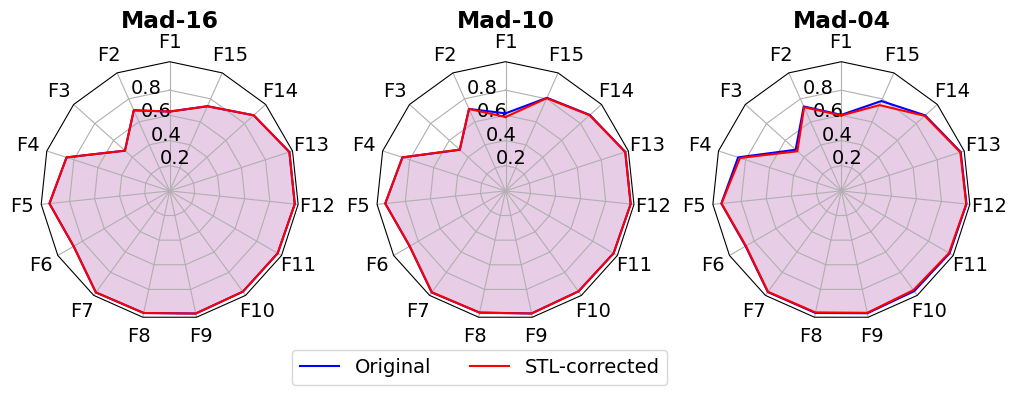

In [29]:
backends = ['Mad-16', 'Mad-10', 'Mad-04']

def get_values(data, backend_name, feature_name, stat='mean'):
    g = data[data['backend'] == backend_name].groupby(['problem'])

    match stat:
        case 'median':
            return [v[feature_name].median() for _, v in g]

        case 'mean':
            return [v[feature_name].mean() for _, v in g]

        case 'max':
            return [v[feature_name].max() for _, v in g]

        case 'min':
            return [v[feature_name].min() for _, v in g]


header = [f'F{i}' for i in range(1, 16)]
print(header)

runs_data = runs_without_nls
runs_data.r2_test_v = runs_data.r2_test_v.clip(0, 1)
runs_data.r2_test_b = runs_data.r2_test_b.clip(0, 1)

data = [
    ('Mad-16',
     [get_values(runs_data, 'Mad_Transcendental_Fast', 'r2_test_b', stat='median'),
      get_values(runs_data, 'Mad_Transcendental_Fast', 'r2_test_v', stat='median')]),
    ('Mad-10',
     [get_values(runs_data, 'Mad_Transcendental_Faster', 'r2_test_b', stat='median'),
      get_values(runs_data, 'Mad_Transcendental_Faster', 'r2_test_v', stat='median')]),
    ('Mad-04',
     [get_values(runs_data, 'Mad_Transcendental_Fastest', 'r2_test_b', stat='median'),
      get_values(runs_data, 'Mad_Transcendental_Fastest', 'r2_test_v', stat='median')]
    )
]

spoke_labels = header
colors = ['b', 'r', 'g', 'm', 'y']
labels = ('Original', 'STL-corrected')


theta = radar_factory.radar_factory(len(header), frame='polygon')

fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=3,
                        subplot_kw=dict(projection='radar'))
for ax, (title, case_data) in zip(axs.flat, data):

    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])

legend = axs[0].legend(labels, labelspacing=0.1, fontsize=14, loc='upper center', bbox_to_anchor=(1.7, -0.08), ncols=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.25)
# fig.tight_layout()
plt.savefig('correction.pdf', bbox_inches='tight')

In [30]:
data = [
    ('Eigen',
     [get_values(runs_without_nls, 'Eigen', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Eigen', 'r2_test_v', stat='median')]),
    ('Stl',
     [get_values(runs_without_nls, 'Stl', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Stl', 'r2_test_v', stat='median')]),
    ('Vdt',
    [get_values(runs_without_nls, 'Vdt', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Vdt', 'r2_test_v', stat='median')]),
    ('Mad-16',
     [get_values(runs_without_nls, 'Mad_Transcendental_Fast', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Mad_Transcendental_Fast', 'r2_test_v', stat='median')]),
    ('Mad-10',
     [get_values(runs_without_nls, 'Mad_Transcendental_Faster', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Mad_Transcendental_Faster', 'r2_test_v', stat='median')]),
    ('Mad-04',
     [get_values(runs_without_nls, 'Mad_Transcendental_Fastest', 'r2_test_v', stat='median'),
      get_values(runs_with_nls, 'Mad_Transcendental_Fastest', 'r2_test_v', stat='median')]
    )
]
data

[('Eigen',
  [[0.604055138990477,
    0.6978559676775407,
    0.4813865593526865,
    0.8612911320165797,
    0.959938341264831,
    0.8775888712719976,
    0.9970125895557008,
    0.9905744224161953,
    0.9961370929589752,
    0.9870846813127991,
    0.9908728740478163,
    0.9996562500486617,
    0.9999902171864019,
    0.897280724973676,
    0.7899572044915362],
   [0.5811912219303106,
    0.811896665675653,
    0.44627667397070503,
    0.8650582917812253,
    0.9601239195770437,
    0.8743203747179229,
    0.9934410223487122,
    0.9974547491462118,
    0.998945186619604,
    0.9991461645177312,
    0.9277534115329531,
    0.9999999456988572,
    0.9999999996735671,
    0.9999999953047947,
    0.8479664319108514]]),
 ('Stl',
  [[0.6179560104480541,
    0.7083436533914131,
    0.4834511911110748,
    0.8607364798866598,
    0.960032580448511,
    0.889327604713691,
    0.9968627628835205,
    0.988872236004642,
    0.9968526587120901,
    0.9879132167808482,
    0.9906495637378867,

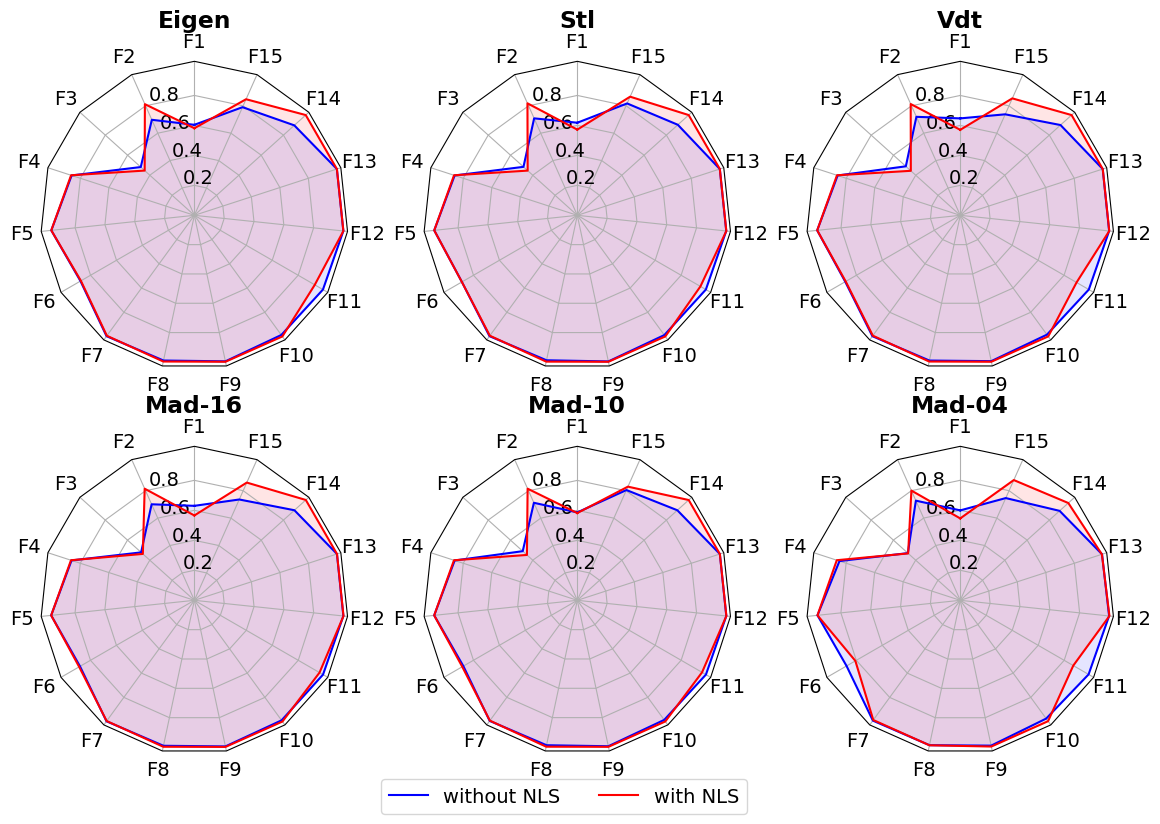

In [31]:

spoke_labels = header
colors = ['b', 'r', 'g', 'm', 'y']
labels = ('without NLS', 'with NLS')


theta = radar_factory.radar_factory(len(header), frame='polygon')

fig, axs = plt.subplots(figsize=(14, 9), nrows=2, ncols=3,
                        subplot_kw=dict(projection='radar'))
for ax, (title, case_data) in zip(axs.flat, data):

    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])

legend = axs[0, 0].legend(labels, labelspacing=0.1, fontsize=14, loc='upper center', bbox_to_anchor=(1.7, -1.3), ncols=2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.25)
plt.savefig('r2_test.pdf', bbox_inches='tight')

### Median difference of MAD-* vs Eigen

In [32]:
runs = runs_with_nls
eigen = runs[runs.backend == 'Eigen']
problems = runs.problem.unique()
backends = ['Mad_Transcendental_Fast', 'Mad_Transcendental_Faster', 'Mad_Transcendental_Fastest']

for i, p in enumerate(problems):
    m1 = eigen[eigen.problem == p]['r2_test_v'].clip(0,1).median()

    for j, b in enumerate(backends):
        m2 = runs[(runs.backend == b) & (runs.problem == p)]['r2_test_v'].clip(0,1).median()

        # print(b, end=' & ')
        print(f'{100*(m2-m1)/m1:.2f}', end=' & ')
        # print(f'{(m2-m1):.4f}', end=' & ')
    print()


-2.64 & 0.17 & -6.07 & 
0.35 & 0.40 & -1.38 & 
3.62 & 1.37 & 4.72 & 
-0.00 & -0.00 & 0.02 & 
-0.01 & -0.01 & -0.33 & 
0.14 & -0.11 & -0.73 & 
1.47 & 1.37 & -7.66 & 
0.08 & 0.09 & -0.98 & 
0.03 & 0.02 & -0.26 & 
-0.00 & -0.02 & -0.33 & 
3.88 & 3.58 & -6.23 & 
0.00 & -0.00 & -0.02 & 
0.00 & 0.00 & -0.72 & 
-0.00 & 0.00 & -3.07 & 
1.35 & -2.11 & 3.48 & 


### Statistical tests

In [33]:
runs = runs_without_nls
problems = runs.problem.unique()
print(problems)
backends = runs.backend.unique()
print(backends)
eigen = runs[runs.backend == 'Eigen']

names = {
   'Mad_Transcendental_Fast': 'Mad-16',
   'Mad_Transcendental_Faster': 'Mad-10',
   'Mad_Transcendental_Fastest': 'Mad-04',
   'Eigen':'Eigen',
   'Vdt':'Vdt',
   'Stl': 'Stl'
}

sig = np.full(shape=(len(problems), len(backends)-1), fill_value=np.nan)

for i, p in enumerate(problems):
    a = eigen[eigen.problem == p]['r2_test_v'].round(3)

    for j, b in enumerate([b for b in backends if b != 'Eigen']):
        b = runs[(runs.backend == b) & (runs.problem == p)]['r2_test_v'].round(3)

        sig[i, j] = mannwhitneyu(a, b, nan_policy='omit', alternative='greater')[1]

sig

stats = pd.DataFrame(data=sig, index=[f'$F_{{{i}}}$' for i in range(1, len(problems)+1)], columns=[b for b in backends if b != 'Eigen'])
stats.columns = [names[b] for b in backends if b != 'Eigen']
stats = stats[['Mad-16', 'Mad-10', 'Mad-04']]
stats

['Airfoil Self-Noise' 'Chemical-I' 'Concrete Compressive Strength'
 'Friedman-I' 'Friedman-II' 'Spatial Coevolution' 'Poly-10'
 'Vladislavleva-1' 'Vladislavleva-2' 'Vladislavleva-3' 'Vladislavleva-4'
 'Vladislavleva-5' 'Vladislavleva-6' 'Vladislavleva-7' 'Vladislavleva-8']
['Mad_Transcendental_Faster' 'Mad_Transcendental_Fast' 'Eigen' 'Vdt'
 'Mad_Transcendental_Fastest' 'Stl']


,Mad-16,Mad-10,Mad-04
$F_{1}$,0.844738,0.186194,5.534587e-01
$F_{2}$,0.834900,0.840315,9.832909e-01
$F_{3}$,0.452348,0.781793,4.215525e-01
$F_{4}$,0.492150,0.010495,1.632315e-25
$F_{5}$,0.822847,0.521999,1.808181e-03
$F_{6}$,0.663649,0.036175,1.923537e-08
$F_{7}$,0.635614,0.411721,2.557179e-01
$F_{8}$,0.568468,0.126936,3.575169e-02
$F_{9}$,0.418234,0.261900,1.242962e-06
$F_{10}$,0.894510,0.243618,8.714716e-05


In [34]:
table = stats.to_latex(index=False, float_format='{:.1e}'.format)
print(table)

\begin{tabular}{rrr}
\toprule
Mad-16 & Mad-10 & Mad-04 \\
\midrule
8.4e-01 & 1.9e-01 & 5.5e-01 \\
8.3e-01 & 8.4e-01 & 9.8e-01 \\
4.5e-01 & 7.8e-01 & 4.2e-01 \\
4.9e-01 & 1.0e-02 & 1.6e-25 \\
8.2e-01 & 5.2e-01 & 1.8e-03 \\
6.6e-01 & 3.6e-02 & 1.9e-08 \\
6.4e-01 & 4.1e-01 & 2.6e-01 \\
5.7e-01 & 1.3e-01 & 3.6e-02 \\
4.2e-01 & 2.6e-01 & 1.2e-06 \\
8.9e-01 & 2.4e-01 & 8.7e-05 \\
3.2e-01 & 7.1e-01 & 8.4e-05 \\
1.4e-01 & 2.4e-01 & 2.0e-02 \\
1.4e-02 & 2.1e-01 & 2.0e-13 \\
7.8e-01 & 4.9e-01 & 2.4e-02 \\
2.0e-01 & 4.4e-01 & 1.6e-01 \\
\bottomrule
\end{tabular}



In [35]:
styler = stats.style\
  .background_gradient(axis=None, cmap="gray", vmin=-0.05, vmax=0.1)\
  .highlight_null(props="background-color:white; color:white;")\
  .format('{:.1e}')\
  .format_index(escape="latex", axis=1)

styler

,Mad-16,Mad-10,Mad-04
$F_{1}$,8.4e-01,1.9e-01,5.5e-01
$F_{2}$,8.3e-01,8.4e-01,9.8e-01
$F_{3}$,4.5e-01,7.8e-01,4.2e-01
$F_{4}$,4.9e-01,1.0e-02,1.6e-25
$F_{5}$,8.2e-01,5.2e-01,1.8e-03
$F_{6}$,6.6e-01,3.6e-02,1.9e-08
$F_{7}$,6.4e-01,4.1e-01,2.6e-01
$F_{8}$,5.7e-01,1.3e-01,3.6e-02
$F_{9}$,4.2e-01,2.6e-01,1.2e-06
$F_{10}$,8.9e-01,2.4e-01,8.7e-05


In [36]:
table = styler.to_latex(convert_css=True)
print(table)

\begin{tabular}{lrrr}
 & Mad-16 & Mad-10 & Mad-04 \\
$F_{1}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 8.4e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 1.9e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 5.5e-01 \\
$F_{2}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 8.3e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 8.4e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 9.8e-01 \\
$F_{3}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 4.5e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 7.8e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 4.2e-01 \\
$F_{4}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 4.9e-01 & {\cellcolor[HTML]{676767}} \color[HTML]{F1F1F1} 1.0e-02 & {\cellcolor[HTML]{555555}} \color[HTML]{F1F1F1} 1.6e-25 \\
$F_{5}$ & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 8.2e-01 & {\cellcolor[HTML]{FFFFFF}} \color[HTML]{000000} 5.2e-01 & {\cellcolor[HTML]{585858}} \color[HTML]{F1F1F1} 1.8e-03 \\
$F_{6}$ & {\cellcolor[